# QUALITY CONTROL
The purpose of this notebook is to provide a comprehensive quality control (QC) and overview of the data generated by the Xenium platform. 

By combining both standard transcriptomics QC metrics and segmentation-specific assessments, this notebook serves as a first-pass evaluation of dataset quality and consistency across samples and conditions.

Specifically, this notebook aims to:
>1.	Summarize the segmentation strategies used and evaluate their impact on cell size, transcript density, and overall cell counts.
>2.	Provide an overview of transcript-level QC metrics, including total counts, detected genes per cell, and mitochondrial transcript fractions, to identify potential low-quality cells or outlier samples.
>3.	Compare QC metrics across samples and experimental conditions to highlight technical variation or biases that could confound biological interpretation.
>4.	Establish a transparent baseline for downstream analyses, ensuring that filtering decisions and biological conclusions are built on well-documented QC checks.

In short, this notebook is designed to give both a high-level overview and detailed QC insights, enabling researchers to quickly assess data quality and gain confidence in subsequent analyses.

## IMPORT PACKAGES

In [110]:
path = '/Volumes/jamboree/spatial/20250725__090712__Tuany_mSkinMelanoma5k_run1/output-XETG00045__0059973__c57__20250725__091031/transcripts.parquet'
df = pd.read_parquet(path, engine="pyarrow")

In [105]:
import os
import re
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
# Global plotting style
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)
plt.rcParams['figure.dpi'] = 120

import seaborn as sns

def read_transcripts_parquet(tp):
    """
    Read Xenium transcripts.parquet and normalize to have a 'gene' column.
    """
    df = pd.read_parquet(tp, engine="pyarrow")  # super fast
    # common column names
    gene_cols = ["feature_name", "gene", "target", "Gene", "FeatureName"]
    gcol = None
    for c in gene_cols:
        if c in df.columns:
            gcol = c
            break
    if gcol is None:
        raise ValueError(f"No gene column found in {tp}. Columns: {df.columns.tolist()[:10]}")

    df = df.rename(columns={gcol: "gene"})
    return df[["gene"]] if "gene" in df.columns else df

def make_palette(values, base_palette=None):
    """
    Extend a palette dict to cover all categories in `values`.
    If a category is missing, assign it a default Seaborn color.
    """
    unique = pd.Series(values).dropna().unique()
    if base_palette is None:
        base_palette = {}
    palette = dict(base_palette)  # copy
    missing = [x for x in unique if x not in palette]
    if missing:
        extra_colors = sns.color_palette("tab10", n_colors=len(missing))
        palette.update(dict(zip(missing, extra_colors)))
    return palette

# Example:
seg_palette_full = make_palette(adata_all.obs["tissue"], seg_palette)

### SPECIFY PATH

In [99]:
base_dir = "/Volumes/jamboree/spatial/20250725__090712__Tuany_mSkinMelanoma5k_run1"
runs = [base_dir]  # or multiple run folders if you have them

## TRANSCRIPTS FILE SUMMARY

In this step we load the `transcripts.parquet` file for each sample and generate basic summary statistics.  
For every sample we record:

- Total number of transcripts detected  
- Number of unique "genes" with at least one transcript  
- Number and fraction of transcripts mapping to negative-control probes  
- Associated metadata (tissue, genotype, timepoint, condition)  

In [106]:
sample_summaries = []
per_sample_gene_counts = {}

for run in runs:
    run_path = os.path.join(run)
    samples = [s for s in os.listdir(run_path)
               if os.path.isdir(os.path.join(run_path, s)) and not s.startswith(".")]

    for sample in samples:
        sample_path = os.path.join(run_path, sample)
        t_path = os.path.join(sample_path, "transcripts.parquet")
        if not os.path.exists(t_path):
            print(f"[transcripts] Skipping {sample} (no transcripts.parquet)")
            continue

        meta = parse_condition(sample)

        # read parquet + tally
        tx = read_transcripts_parquet(t_path)
        n_tx = len(tx)
        gene_counts = tx["gene"].value_counts()
        n_genes = gene_counts.size

        # crude negative control detection (adapt to your panel naming)
        neg_patterns = [r"^Neg", r"^NEG", r"^Blank", r"^BLANK", r"^Control", r"^CTRL"]
        is_neg = gene_counts.index.str.contains("|".join(neg_patterns), regex=True)
        neg_count = int(gene_counts[is_neg].sum()) if is_neg.any() else 0
        neg_frac = neg_count / n_tx if n_tx > 0 else np.nan

        per_sample_gene_counts[sample] = gene_counts
        sample_summaries.append({
            "sample_folder": sample,
            "tissue": meta.get("tissue"),
            "genotype": meta.get("genotype"),
            "timepoint": meta.get("timepoint"),
            "condition": meta.get("condition"),
            "n_transcripts": n_tx,
            "n_genes_detected": n_genes,
            "neg_control_transcripts": neg_count,
            "neg_control_fraction": neg_frac,
        })

df_tx_summary = pd.DataFrame(sample_summaries).sort_values("sample_folder")
display(df_tx_summary)

,sample_folder,tissue,genotype,timepoint,condition,n_transcripts,n_genes_detected,neg_control_transcripts,neg_control_fraction
2,output-XETG00045__0059973__Oprl1_cre__20250725...,tumor,Oprl1_cre,None,Oprl1_cre,19634207,10393,1555,0.000079
6,output-XETG00045__0059973__Oprl1_wt__20250725_...,tumor,Oprl1_wt,None,Oprl1_wt,4997816,6660,456,0.000091
10,output-XETG00045__0059973__Pdl1_cre__20250725_...,tumor,Pdl1_cre,None,Pdl1_cre,16635064,8983,2897,0.000174
1,output-XETG00045__0059973__Pdl1_wt__20250725__...,tumor,Pdl1_wt,None,Pdl1_wt,3128189,6750,450,0.000144
4,output-XETG00045__0059973__c57__20250725__091031,tumor,c57,None,c57,85104137,13780,17609,0.000207
8,output-XETG00045__0059976__cre_24h__20250725__...,skin,cre,24h,cre_24h,1206202,6818,863,0.000715
5,output-XETG00045__0059976__cre_72h__20250725__...,skin,cre,72h,cre_72h,2272389,6496,879,0.000387
0,output-XETG00045__0059976__litt_24h__20250725_...,skin,litt,24h,litt_24h,2086770,7177,960,0.000460
3,output-XETG00045__0059976__litt_72h__20250725_...,skin,litt,72h,litt_72h,2057786,6190,926,0.000450
9,output-XETG00045__0059976__wt_24h__20250725__0...,skin,wt,24h,wt_24h,1404516,5899,612,0.000436


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_80693/1605678957.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  sns.despine(); plt.tight_layout()


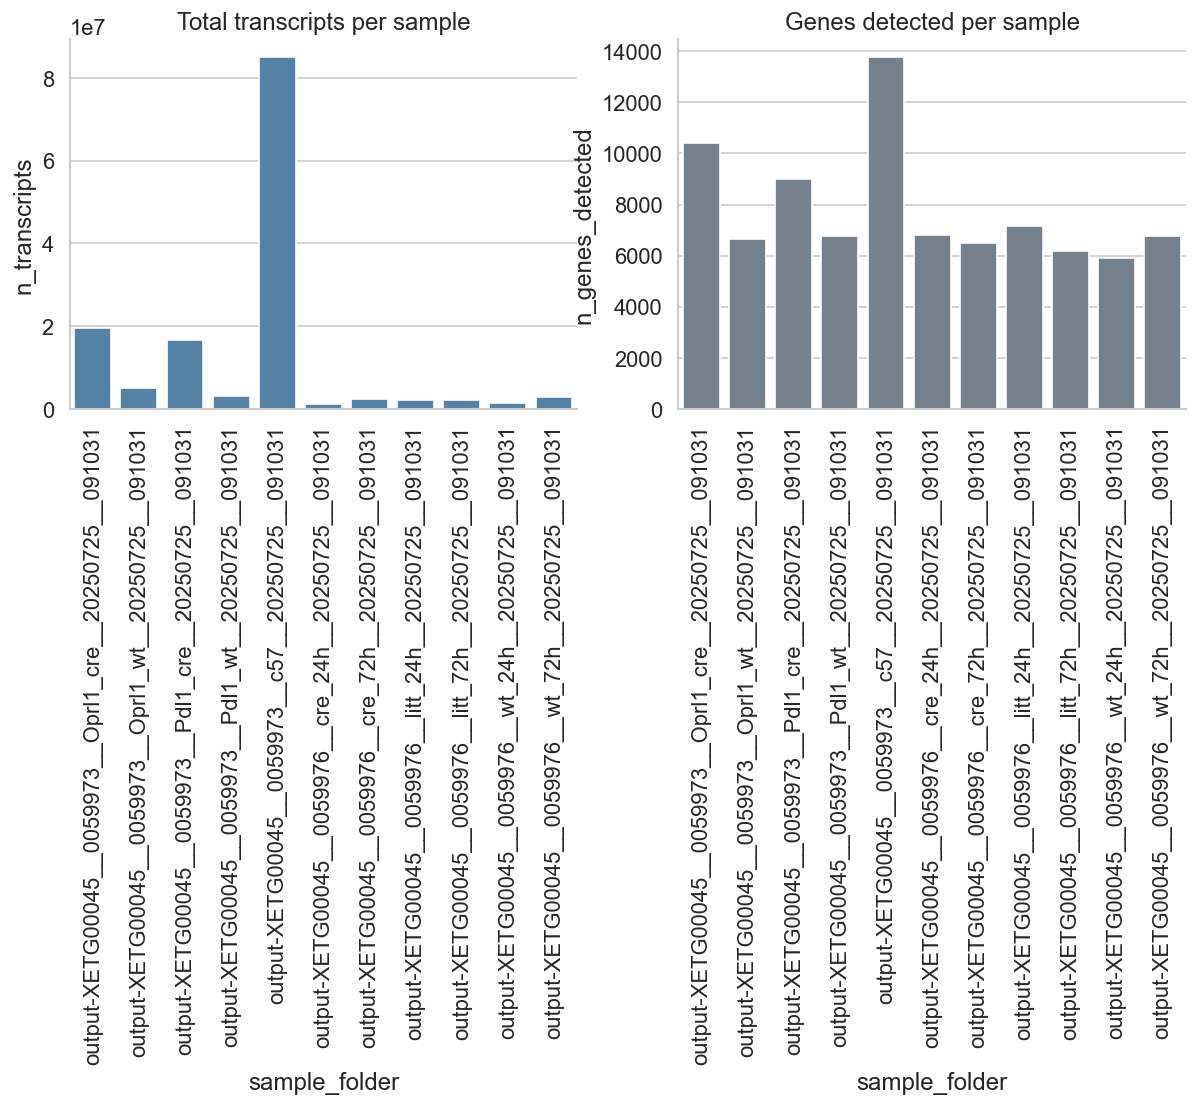

In [109]:
# Total transcripts and genes per sample
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)
sns.barplot(data=df_tx_summary, x="sample_folder", y="n_transcripts", color="steelblue", ax=axes[0])
axes[0].set_title("Total transcripts per sample"); axes[0].tick_params(axis='x', rotation=90)
sns.barplot(data=df_tx_summary, x="sample_folder", y="n_genes_detected", color="slategray", ax=axes[1])
axes[1].set_title("Genes detected per sample"); axes[1].tick_params(axis='x', rotation=90)
sns.despine(); plt.tight_layout()

## CONSTRUCT ANNDATA OBJECT

In [140]:
sample

'output-XETG00045__0059973__Pdl1_cre__20250725__091031'

In [141]:
for run in runs:
    run_path = os.path.join(run)

    # only directories (skip .DS_Store)
    samples = [s for s in os.listdir(run_path)
               if os.path.isdir(os.path.join(run_path, s)) and not s.startswith(".")]

    for sample in samples:
        print(sample)

output-XETG00045__0059976__litt_24h__20250725__091031
output-XETG00045__0059973__Pdl1_wt__20250725__091031
output-XETG00045__0059973__Oprl1_cre__20250725__091031
output-XETG00045__0059976__litt_72h__20250725__091031
output-XETG00045__0059973__c57__20250725__091031
output-XETG00045__0059976__cre_72h__20250725__091031
output-XETG00045__0059973__Oprl1_wt__20250725__091031
output-XETG00045__0059976__wt_72h__20250725__091031
output-XETG00045__0059976__cre_24h__20250725__091031
output-XETG00045__0059976__wt_24h__20250725__091031
output-XETG00045__0059973__Pdl1_cre__20250725__091031


In [142]:
ad_list = []
# ----- helpers -----
def parse_condition(sample_folder_name: str):
    """
    Your folders look like:
      output-XETG00045__0059976__litt_24h__20250725__091031
    The 'condition' is the 3rd token between '__': e.g. 'litt_24h'
    """
    parts = sample_folder_name.split("__")
    cond = parts[2] if len(parts) >= 3 else sample_folder_name

    # skin side (time-resolved)
    m = re.match(r"^(wt|cre|litt)_(\d+h)$", cond)
    if m:
        geno, tp = m.group(1), m.group(2)
        return {"condition": cond, "tissue": "skin", "genotype": geno, "timepoint": tp}

    # tumor side (genotype only)
    tumor_genos = {"Oprl1_cre","Oprl1_wt","Pdl1_cre","Pdl1_wt","c57"}
    if cond in tumor_genos:
        return {"condition": cond, "tissue": "tumor", "genotype": cond, "timepoint": None}

    # fallback
    return {"condition": cond, "tissue": None, "genotype": None, "timepoint": None}


def read_cells_csv(cell_info_path: str):
    df = pd.read_csv(cell_info_path, low_memory=False)
    # Try to find an index column
    idx_col = None
    for cand in ["cell_id", "barcode", "cellID", "id", "Unnamed: 0"]:
        if cand in df.columns:
            idx_col = cand
            break
    if idx_col is not None:
        df = df.set_index(idx_col)
    # If it's already indexed correctly, keep it
    if df.index.name is None:
        # last resort: use first column as index
        df = df.set_index(df.columns[0])
    return df


# ----- load -----
for run in runs:
    run_path = os.path.join(run)

    # only directories (skip .DS_Store)
    samples = [s for s in os.listdir(run_path)
               if os.path.isdir(os.path.join(run_path, s)) and not s.startswith(".")]

    for sample in samples:
        sample_path = os.path.join(run_path, sample)
        h5_path = os.path.join(sample_path, "cell_feature_matrix.h5")
        cell_info_path = os.path.join(sample_path, "cells.csv.gz")

        if not (os.path.exists(h5_path) and os.path.exists(cell_info_path)):
            print(f"Skipping {sample_path} (missing required files)")
            continue

        meta = parse_condition(sample)
        print(f"Loading: {sample}  →  {meta}")

        # 1) read counts
        ad_int = sc.read_10x_h5(h5_path)  # genes in .var, cells in .obs (barcodes)
        ad_int.var_names_make_unique()

        # 2) read and join cell metadata
        cell_info = read_cells_csv(cell_info_path)

        # ensure indices align: join by obs_names (barcodes)
        # (never overwrite ad_int.obs entirely—preserve existing cols)
        ad_int.obs = ad_int.obs.join(cell_info, how="left")

        # 3) add run/sample + parsed metadata
        ad_int.obs["run"] = os.path.basename(run)
        ad_int.obs["sample_folder"] = sample
        ad_int.obs['sample___'] = sample
        for k, v in meta.items():
            ad_int.obs[k] = v

        # 4) make obs names unique per sample
        ad_int.obs_names = sample + "_" + ad_int.obs_names.astype(str)

        ad_list.append(ad_int)

# ----- concatenate -----
if len(ad_list) == 0:
    raise RuntimeError("No samples loaded.")

adata_all = sc.concat(
    ad_list,
    label="sample_folder",
    join="outer",
    fill_value=0
)

print(adata_all)
print("Samples loaded:", adata_all.obs["sample_folder"].unique())
print("Tissues:", adata_all.obs["tissue"].value_counts(dropna=False))
print("Genotypes:", adata_all.obs["genotype"].value_counts(dropna=False))
print("Timepoints:", adata_all.obs["timepoint"].value_counts(dropna=False))

Loading: output-XETG00045__0059976__litt_24h__20250725__091031  →  {'condition': 'litt_24h', 'tissue': 'skin', 'genotype': 'litt', 'timepoint': '24h'}
Loading: output-XETG00045__0059973__Pdl1_wt__20250725__091031  →  {'condition': 'Pdl1_wt', 'tissue': 'tumor', 'genotype': 'Pdl1_wt', 'timepoint': None}
Loading: output-XETG00045__0059973__Oprl1_cre__20250725__091031  →  {'condition': 'Oprl1_cre', 'tissue': 'tumor', 'genotype': 'Oprl1_cre', 'timepoint': None}
Loading: output-XETG00045__0059976__litt_72h__20250725__091031  →  {'condition': 'litt_72h', 'tissue': 'skin', 'genotype': 'litt', 'timepoint': '72h'}
Loading: output-XETG00045__0059973__c57__20250725__091031  →  {'condition': 'c57', 'tissue': 'tumor', 'genotype': 'c57', 'timepoint': None}
Loading: output-XETG00045__0059976__cre_72h__20250725__091031  →  {'condition': 'cre_72h', 'tissue': 'skin', 'genotype': 'cre', 'timepoint': '72h'}
Loading: output-XETG00045__0059973__Oprl1_wt__20250725__091031  →  {'condition': 'Oprl1_wt', 'tissue

## SEGMENTATION STATISTICS
In this section we summarize how cells were segmented across samples.
Different segmentation methods (interior stain, boundary stain, nucleus expansion) can influence downstream QC metrics such as transcript counts, detected genes, and cell area.

Goals of this section:

- Quantify how many cells were segmented by each method.
- Visualize the relative contribution of each segmentation method per sample and condition.
- Identify whether certain samples rely disproportionately on a specific segmentation strategy.

This helps flag potential technical biases in segmentation that should be considered when interpreting QC metrics and biological results.

In [147]:
# Define segmentation palette
palette_segmentation = make_palette(adata_all.obs["segmentation_method"])

,# Cells
segmentation_method,
Segmented by interior stain (18S),378745
Segmented by boundary stain (ATP1A1+CD45+E-Cadherin),78444
Segmented by nucleus expansion of 5.0µm,45594


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_80693/3318524595.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_80693/3318524595.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


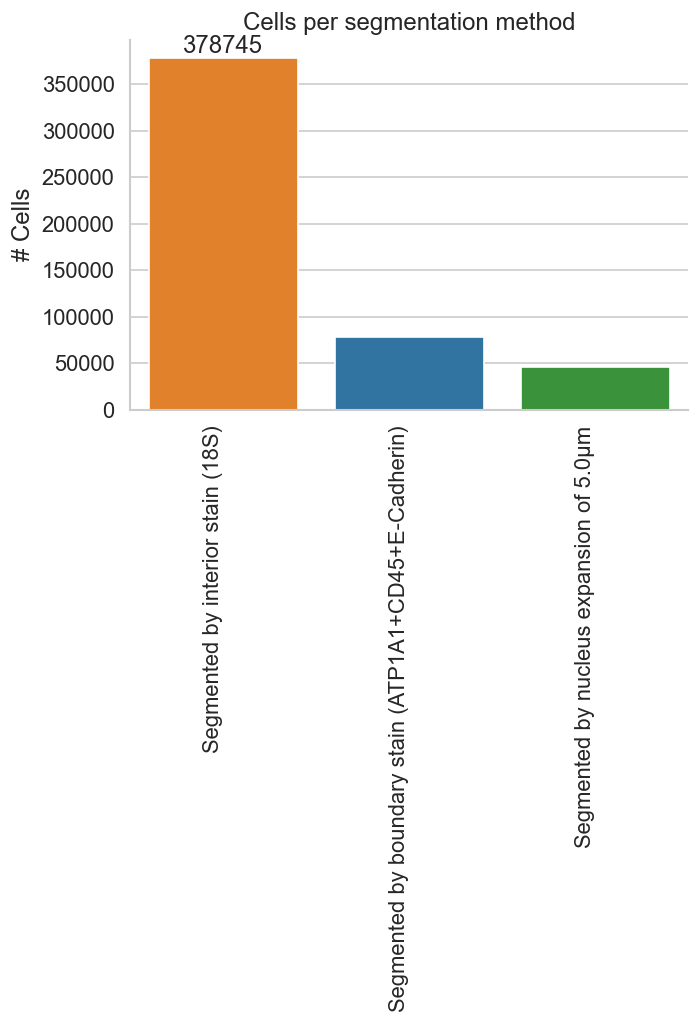

In [148]:
def plot_counts_by_segmentation(adata, seg_col="segmentation_method", palette=None):
    counts = adata.obs[seg_col].value_counts().sort_values(ascending=False)
    display(pd.DataFrame({'# Cells': counts}).rename_axis(seg_col))

    if palette is None:
        palette = palette_segmentation  # fall back to your global palette

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(
        x=counts.index,
        y=counts.values,
        palette=[palette.get(x, "gray") for x in counts.index],
        ax=ax
    )
    ax.set_ylabel("# Cells")
    ax.set_xlabel("")
    ax.set_title("Cells per segmentation method")
    ax.bar_label(ax.containers[0], fmt="%.0f", label_type="edge")
    plt.xticks(rotation=90, ha="right")
    sns.despine()
    plt.tight_layout()

# Use your palette
plot_counts_by_segmentation(adata_all, palette=palette_segmentation)

segmentation_method,Segmented by boundary stain (ATP1A1+CD45+E-Cadherin),Segmented by interior stain (18S),Segmented by nucleus expansion of 5.0µm
condition,,,
Oprl1_cre,14537,39206,2020
Oprl1_wt,6105,21317,1584
Pdl1_cre,15438,73521,6761
Pdl1_wt,3811,19513,1466
c57,15237,56377,2531
cre_24h,2025,22827,5705
cre_72h,6072,31144,4291
litt_24h,4032,36035,4937
litt_72h,3419,23471,5417


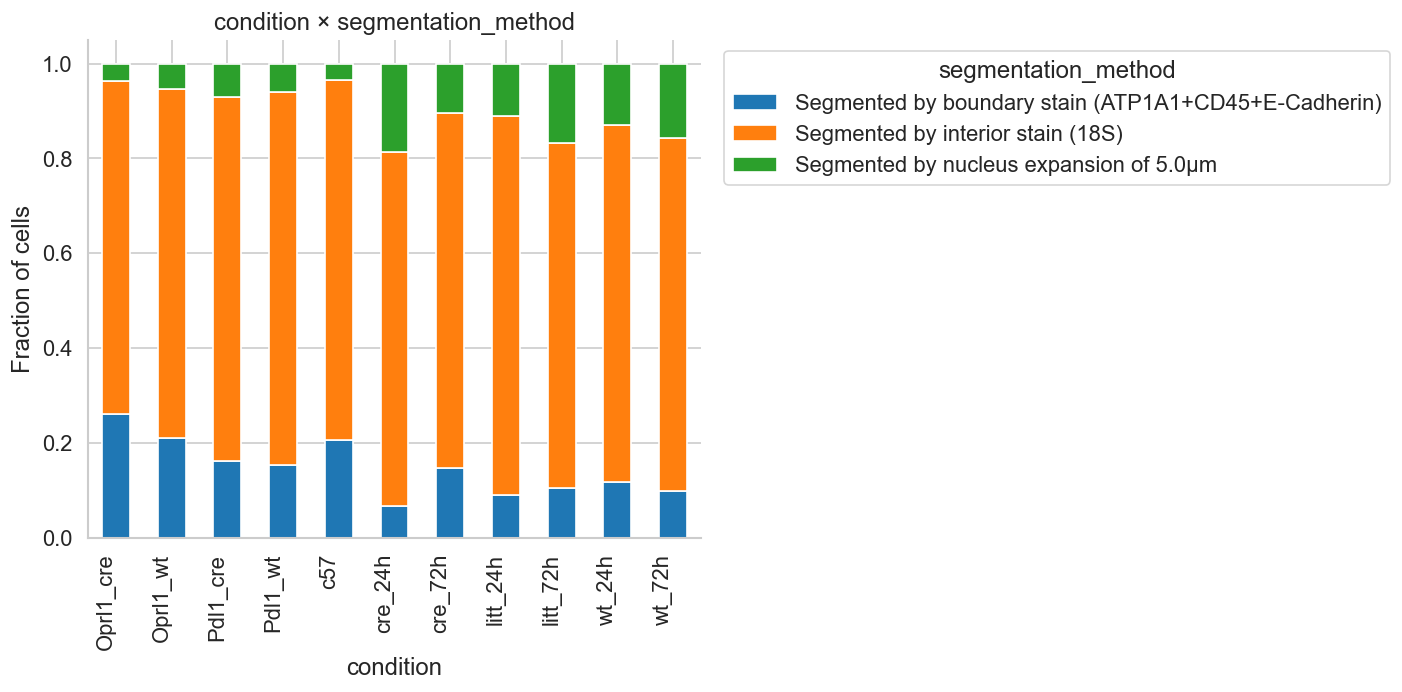

In [149]:
def stacked_bar(adata, by="sample", seg_col="segmentation_method", palette=None):
    if by not in adata.obs.columns:
        return
    
    ct = pd.crosstab(adata.obs[by], adata.obs[seg_col])
    display(ct)

    frac = ct.div(ct.sum(1), axis=0)

    # use provided palette or fall back to global palette_segmentation
    if palette is None:
        palette = palette_segmentation

    frac.plot(
        kind="bar",
        stacked=True,
        figsize=(12, 6),
        color=[palette.get(c, "gray") for c in frac.columns]
    )
    plt.ylabel("Fraction of cells")
    plt.title(f"{by} × {seg_col}")
    plt.xticks(rotation=90, ha="right")
    plt.legend(title=seg_col, bbox_to_anchor=(1.02, 1), loc="upper left")
    sns.despine()
    plt.tight_layout()


# usage with your palette
stacked_bar(adata_all, by="sample", palette=palette_segmentation)
if "condition" in adata_all.obs:
    stacked_bar(adata_all, by="condition", palette=palette_segmentation)

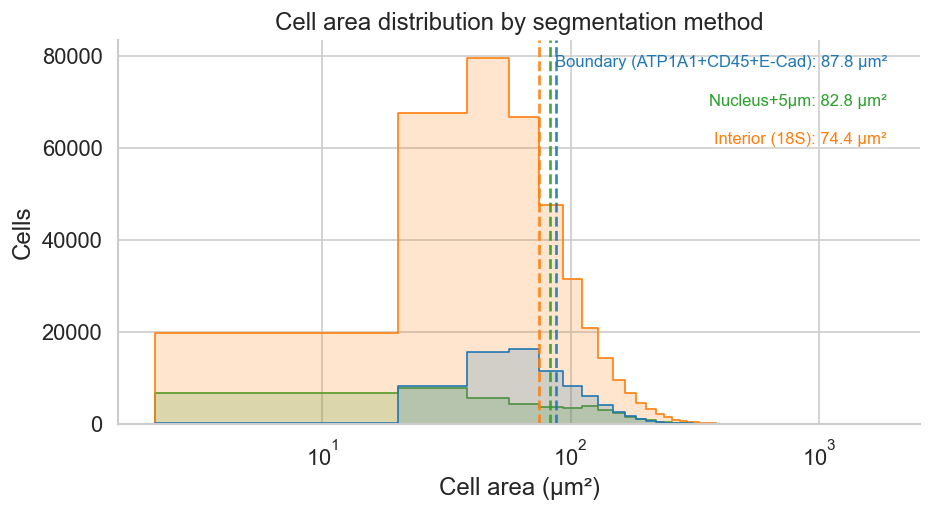

In [150]:
# 1) optional: shorten long method strings for nicer plotting
short_map = {
    "Segmented by interior stain (18S)": "Interior (18S)",
    "Segmented by boundary stain (ATP1A1+CD45+E-Cadherin)": "Boundary (ATP1A1+CD45+E-Cad)",
    "Segmented by nucleus expansion of 5.0µm": "Nucleus+5µm",
}
adata_all.obs["seg_method_short"] = adata_all.obs["segmentation_method"].map(short_map).fillna(adata_all.obs["segmentation_method"])

# 2) make a matching palette for the short labels
palette_seg_short = {short_map.get(k, k): v for k, v in palette_segmentation.items()}

# 3) plot histogram + means, tidy labels on right
if "cell_area" in adata_all.obs.columns:
    import numpy as np
    fig, ax = plt.subplots(figsize=(8, 4.5))
    sns.histplot(
        data=adata_all.obs,
        x="cell_area",
        hue="seg_method_short",
        element="step",
        common_norm=False,
        bins=100,
        palette=palette_seg_short,
        alpha=0.2,
        ax=ax,
        legend=False  # we'll annotate instead of using the default legend
    )

    # dashed mean lines
    means = (
        adata_all.obs.groupby("seg_method_short")["cell_area"]
        .mean()
        .sort_values(ascending=False)  # sort so labels stack top→bottom by mean
    )

    for method, mean_val in means.items():
        color = palette_seg_short.get(method, "gray")
        ax.axvline(mean_val, color=color, linestyle="--", lw=1.6, alpha=0.9)

    # right-side mean labels (stacked)
    ymax = ax.get_ylim()[1]
    xmax = ax.get_xlim()[1]
    y0 = 0.96  # start near top
    step = 0.10 if len(means) <= 3 else 0.08  # vertical spacing
    for i, (method, mean_val) in enumerate(means.items()):
        y = ymax * (y0 - i * step)
        txt = f"{method}: {mean_val:.1f} µm²"
        ax.text(
            xmax * 0.98, y, txt,
            color=palette_seg_short.get(method, "gray"),
            ha="right", va="top", fontsize=10,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.1, pad=1.5)
        )

    # axes & style
    ax.set_xscale("log")
    ax.set_xlabel("Cell area (µm²)")
    ax.set_ylabel("Cells")
    ax.set_title("Cell area distribution by segmentation method")
    sns.despine()
    plt.tight_layout()

## Take-away
> Cell area distributions across segmentation methods show broadly similar ranges.  
> No major systematic shift toward larger or smaller cells is observed.  
> Segmentation choice is therefore unlikely to bias cell size, and differences in counts/densities are more likely biological.

## TRANSCRIPT STATISTICS

This section provides an overview of **transcript-level quality control metrics** across tissues and samples. These distributions help assess **capture efficiency**, **library complexity**, and potential **technical artifacts**.  

**Goals of this section**  
- Visualize the distribution of total transcript counts per cell across tissues and samples  
- Compare the number of detected genes per cell to evaluate transcriptome complexity  
- Identify systematic differences between samples or tissues that may reflect technical variation or biological heterogeneity  

**Why this matters**  
These plots allow us to check whether transcript capture is consistent across the dataset, highlight low-quality cells or outlier samples, and provide a baseline for downstream filtering.  

In [151]:
import scanpy as sc

# Compute per-cell QC
sc.pp.calculate_qc_metrics(
    adata_all,
    inplace=True,
    percent_top=None,   # you can keep this if you want top-N expressed genes
    log1p=False
)

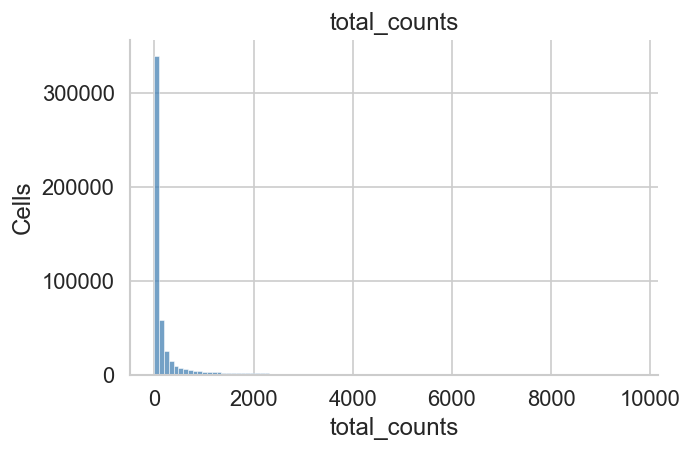

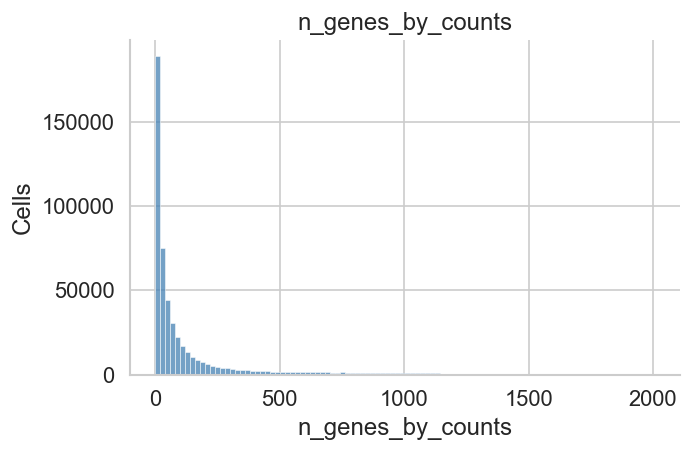

In [152]:
qc_metrics = ["total_counts", "n_genes_by_counts"]
if "pct_counts_mt" in adata_all.obs.columns:
    qc_metrics.append("pct_counts_mt")

for metric in qc_metrics:
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(adata_all.obs[metric], bins=100, kde=False, ax=ax, color="steelblue")
    ax.set_title(metric)
    ax.set_xlabel(metric)
    ax.set_ylabel("Cells")
    sns.despine()
    plt.tight_layout()

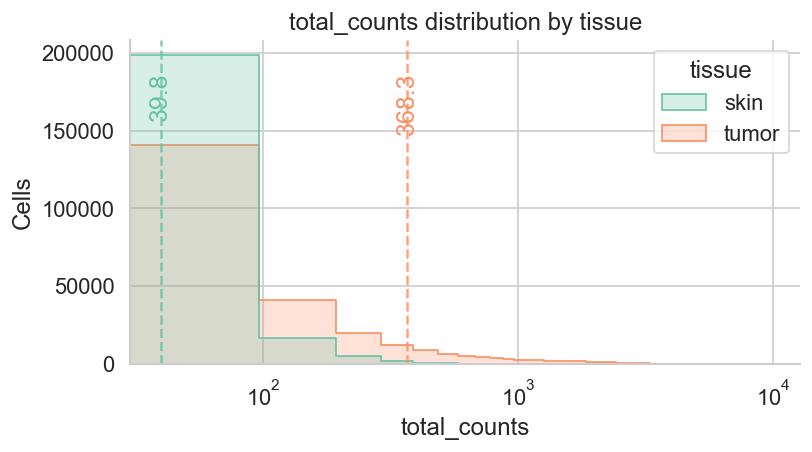

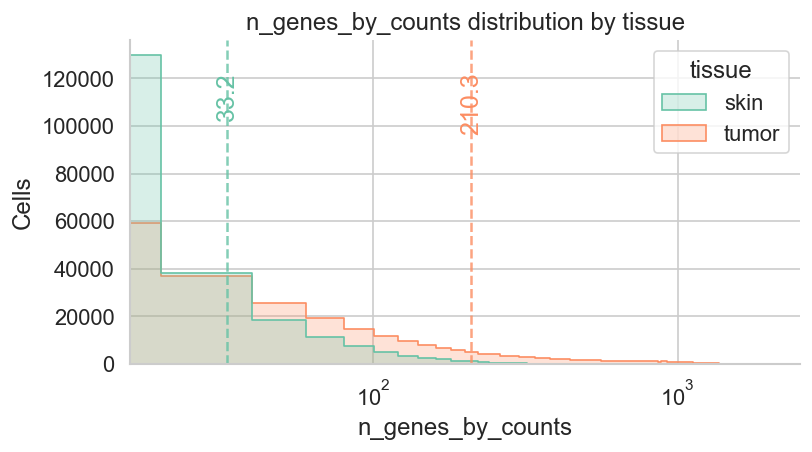

In [153]:
qc_metrics = ["total_counts", "n_genes_by_counts"]
if "pct_counts_mt" in adata_all.obs.columns:
    qc_metrics.append("pct_counts_mt")

for metric in qc_metrics:
    fig, ax = plt.subplots(figsize=(7, 4))
    sns.histplot(
        data=adata_all.obs,
        x=metric,
        hue="tissue",              # stratify by tissue
        element="step",            # outlined histograms
        common_norm=False,
        bins=100,
        palette="Set2",
        ax=ax
    )

    # calculate means per tissue
    means = adata_all.obs.groupby("tissue")[metric].mean()

    # add vertical lines + text
    for i, (tissue, mean_val) in enumerate(means.items()):
        ax.axvline(mean_val, color=sns.color_palette("Set2")[i], linestyle="--", lw=1.5, alpha=0.8)
        ax.text(mean_val, ax.get_ylim()[1]*0.9, f"{mean_val:.1f}",
                color=sns.color_palette("Set2")[i], ha="center", va="top", fontsize=15, rotation=90)

    ax.set_title(f"{metric} distribution by tissue")
    ax.set_xlabel(metric)
    ax.set_ylabel("Cells")

    if metric in ["total_counts", "n_genes_by_counts"]:
        ax.set_xscale("log")

    sns.despine()
    plt.tight_layout()

Text(0.5, 1.05, 'Total counts distribution per sample')

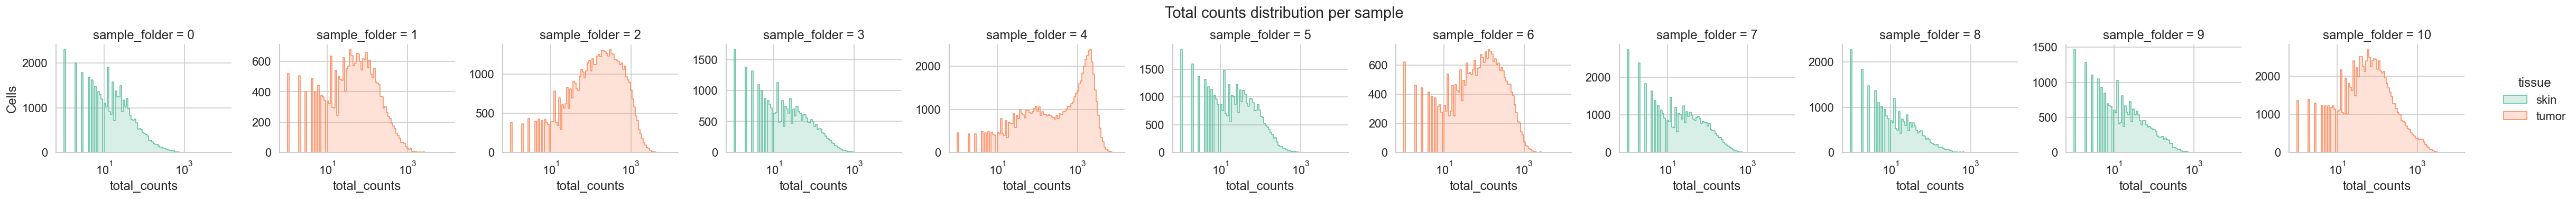

In [154]:
g = sns.displot(
    data=adata_all.obs,
    x="total_counts",
    hue="tissue",
    col="sample_folder",        # facet by sample
    bins=100,
    log_scale=(True, False),
    element="step",
    facet_kws=dict(sharey=False),
    palette="Set2",
    height=3, aspect=1.2, 
)
g.set_axis_labels("total_counts", "Cells")
g.fig.suptitle("Total counts distribution per sample", y=1.05)

In [155]:
adata_all.write('../data/talbot_xenium.h5ad')